downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2929  
Test Loss: 0.29763489961624146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


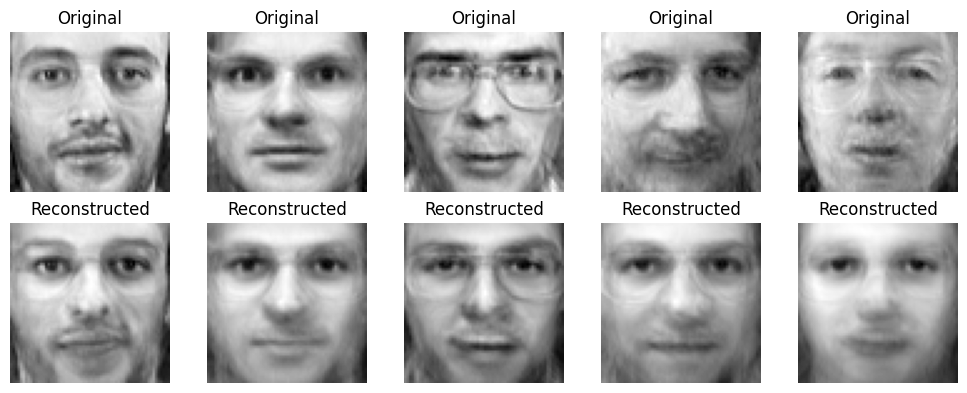

In [1]:
# Import necessary libraries
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load the Olivetti faces dataset
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images
X = data.data  # Flattened image data
y = data.target

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply PCA to preserve 99% of variance
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Define the autoencoder architecture
input_dim = X_train_pca.shape[1]
encoding_dim = input_dim // 2  # Central layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)  # Encoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Decoding layer
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
histories = []

for train_index, val_index in kf.split(X_train_pca):
    print(f"Training fold {fold}...")
    X_fold_train, X_fold_val = X_train_pca[train_index], X_train_pca[val_index]

    # Train the autoencoder
    history = autoencoder.fit(
        X_fold_train, X_fold_train,
        epochs=50,
        batch_size=16,
        validation_data=(X_fold_val, X_fold_val),
        verbose=0
    )
    histories.append(history)
    fold += 1

# Evaluate the autoencoder on the test set
test_loss = autoencoder.evaluate(X_test_pca, X_test_pca)
print(f"Test Loss: {test_loss}")

# Reconstruct images using the trained autoencoder
X_test_reconstructed = autoencoder.predict(X_test_pca)

# Inverse transform the PCA components to the original space
X_test_original_space = pca.inverse_transform(X_test_pca)
X_test_reconstructed_original_space = pca.inverse_transform(X_test_reconstructed)

# Display the original and reconstructed images
n = 5  # Number of images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_original_space[i].reshape(64, 64), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_reconstructed_original_space[i].reshape(64, 64), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.tight_layout()
plt.show()
